# Weak/Integral SINDy Feature Overview

This notebook provides a simple overview of the weak form PDE functionality of PySINDy, following the examples in the PDE-FIND paper (Rudy, Samuel H., Steven L. Brunton, Joshua L. Proctor, and J. Nathan Kutz. "Data-driven discovery of partial differential equations." Science Advances 3, no. 4 (2017): e1602614) and Reinbold et al. (2019).

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dynamicslab/pysindy/v0.13.0?filepath=example%2Ffeature_overview.ipynb)

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint
from sklearn.linear_model import Lasso
from scipy.io import loadmat
import pysindy as ps
from sklearn.metrics import mean_squared_error
np.random.seed(100)

# Test PDE functionality on the Kuramoto-Sivashinsky equation
The Kuramoto-Sivashinsky equation is
$u_t = -uu_x - u_{xx} - u_{xxxx}$.

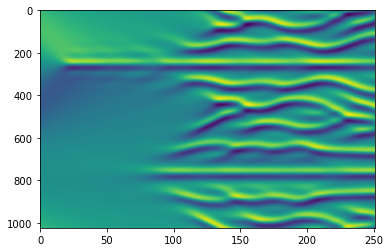

In [2]:
data = loadmat('data/kuramoto_sivishinky.mat')
time = np.ravel(data['tt'])
x = np.ravel(data['x'])
u = data['uu']
u_flattened = np.reshape(u, (len(x) * len(time), 1))
dt = time[1] - time[0]
dx = x[1] - x[0]
plt.figure()
plt.imshow(u, aspect='auto')

# Convert u_t to weak form and then solve problem with all the optimizers

In [3]:
from scipy.interpolate import RectBivariateSpline
from scipy.integrate import trapezoid
from pysindy.differentiation import FiniteDifference

train = range(0, len(time) // 2, 1) # np.random.choice(len(time), int(len(time) * 0.8), replace=False)
test = [i for i in np.arange(len(time)) if i not in train]
u_train = u[:, train]
u_test = u[:, test]
t_train = time[train]
t_test = time[test]

# Flatten into 2D shape for SINDy model optimization
u_train_flattened = np.reshape(u_train, (len(x) * len(t_train), 1))
u_test_flattened = np.reshape(u_test, (len(x) * len(t_test), 1))

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=4, spatial_grid=x, Hx=24.5, Ht=20,
                        temporal_grid=time, include_bias=True,
                        is_uniform=True, weak_form=True, num_pts_per_domain=50)

In [4]:
# Convert ut into a weak form using the pde_lib
def convert_ut(u, t, pde_lib):
    K = pde_lib.K
    domain_centers = pde_lib.domain_centers
    Hx = pde_lib.Hx
    Ht = pde_lib.Ht
    num_pts_per_domain = pde_lib.num_pts_per_domain
    num_time = len(t)
    ut_integral = np.zeros((K, 1))
    u_shaped = np.reshape(u, (len(x), len(t)))
    u_interp = RectBivariateSpline(x, t, u_shaped)
    for k in range(K):
        X = np.ravel(pde_lib.X[k, :, :])
        t = np.ravel(pde_lib.t[k, :, :])
        u_new = u_interp.ev(X, t)
        u_new = np.reshape(u_new, (num_pts_per_domain,
                                   num_pts_per_domain,
                                   1))
        w_diff = pde_lib._smooth_ppoly(
                    np.reshape(pde_lib.xgrid_k[k, :], (num_pts_per_domain, 1)),
                    pde_lib.tgrid_k[k, :], k, 0, 0, 1
                )
        ut_integral[k] = (-1) * (
            trapezoid(
                trapezoid(
                    u_new * w_diff, x=pde_lib.xgrid_k[k, :], axis=0
                ),
                x=pde_lib.tgrid_k[k, :], axis=0
            )
        )
    return ut_integral
ut_train_integral = convert_ut(u_train, t_train, pde_lib)
ut_test_integral = convert_ut(u_test, t_test, pde_lib)
ut_integral = convert_ut(u, time, pde_lib)

In [5]:
optimizer = ps.STLSQ(threshold=0.001, alpha=0.05, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_flattened, x_dot=ut_integral)
model.print()

optimizer = ps.SR3(threshold=0.1, max_iter=10000, tol=1e-15, 
                   thresholder='l0', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_flattened, x_dot=ut_integral)
model.print()

optimizer = ps.SR3(threshold=0.01, max_iter=10000, tol=1e-15, 
                   thresholder='l1', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_flattened, x_dot=ut_integral)
model.print()

# optimizer = ps.SSR(normalize_columns=True, kappa=1e-8)
# model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
# model.fit(u_flattened, x_dot=ut_integral)
# model.print()

# optimizer = ps.SSR(criteria='model_residual', normalize_columns=True, kappa=1e-20)
# model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
# model.fit(u_flattened, x_dot=ut_integral)
# model.print()

optimizer = ps.FROLS(normalize_columns=True, kappa=1e-7)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_flattened, x_dot=ut_integral)
model.print()

x0' = -1.001 x0_11 + -0.011 x0_111 + -1.012 x0_1111 + -1.002 x0x0_1 + 0.002 x0x0x0_11 + 0.002 x0x0x0_1111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 10000 iterations.
  ConvergenceWarning,


x0' = -1.002 x0_11 + -1.021 x0_1111 + -1.003 x0x0_1 + 0.002 x0x0x0_11 + 0.002 x0x0x0_1111
x0' = -1.000 x0_11 + -1.027 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111
x0' = -1.001 x0_11 + -0.011 x0_111 + -1.012 x0_1111 + -1.002 x0x0_1 + 0.002 x0x0x0_11 + 0.002 x0x0x0_1111
x0' = -0.968 x0_11 + -1.002 x0x0_1
x0' = -1.004 x0_11 + -1.051 x0_1111 + -1.004 x0x0_1


In [6]:
# Get average SR3 performance over 10 runs
cross_val_runs = 10
noise_levels = [0, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1]
delta_c1 = np.zeros((cross_val_runs, len(noise_levels)))
delta_c2 = np.zeros((cross_val_runs, len(noise_levels)))
delta_c3 = np.zeros((cross_val_runs, len(noise_levels)))
for i in range(cross_val_runs):
    print(i)
    for j, noise in enumerate(noise_levels):
        pde_lib = ps.PDELibrary(library_functions=library_functions, 
                            function_names=library_function_names, 
                            derivative_order=4, spatial_grid=x, Hx=24.5, Ht=20,
                            temporal_grid=time, include_bias=False, 
                            is_uniform=True, weak_form=True, num_pts_per_domain=50)
        u_noisy = u + np.random.rand(len(x), len(time)) * noise
        u_noisy_flattened = np.ravel(u)
        ut_integral = convert_ut(u_noisy, time, pde_lib)
        optimizer = ps.SR3(threshold=0.01, max_iter=200, tol=1e-10, 
                           thresholder='l1', normalize_columns=True)
        model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
        model.fit(u_noisy_flattened, x_dot=ut_integral)
        model.print()
        c1 = abs(optimizer.coef_[0, 6])
        c2 = abs(optimizer.coef_[0, 3])
        c3 = abs(optimizer.coef_[0, 5])
        delta_c1[i, j] = abs(abs(c1 - 1.0) / c1)
        delta_c2[i, j] = abs(abs(c2 - 1.0) / c2)
        delta_c3[i, j] = abs(abs(c3 - 1.0) / c3)

0


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.998 x0_11 + -0.977 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.999 x0_11 + -0.973 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -1.001 x0_11 + -1.030 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -1.001 x0_11 + -1.026 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.999 x0_11 + -0.972 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.997 x0_11 + -0.960 x0_1111 + -0.999 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -1.006 x0_11 + -1.086 x0_1111 + -1.003 x0x0_1 + 0.001 x0x0x0_1 + 0.001 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = 0.002 x0_1 + -0.970 x0_11 + 0.082 x0_111 + -0.789 x0_1111 + -0.995 x0x0_1 + 0.005 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.003 x0_1 + -1.067 x0_11 + -1.326 x0_1111 + -0.999 x0x0_1 + 0.004 x0x0x0_1 + 0.002 x0x0_11 + 0.009 x0x0x0_11 + 0.006 x0x0_111 + -0.003 x0x0x0_111 + 0.009 x0x0x0_1111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in double_scalars


x0' = 0.003 x0 + 0.010 x0_1 + -0.960 x0_11 + 0.017 x0_111 + -1.088 x0x0_1 + -0.017 x0x0x0_1 + -0.013 x0x0_11 + -0.011 x0x0x0_11 + -0.034 x0x0_111 + -0.001 x0x0x0_111 + -0.013 x0x0_1111 + -0.011 x0x0x0_1111
1


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -1.000 x0_11 + -1.035 x0_1111 + -0.999 x0x0_1 + 0.003 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.999 x0_11 + -1.004 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -1.000 x0_11 + -1.028 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -1.000 x0_11 + -0.990 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.997 x0_11 + -1.005 x0_1111 + -0.999 x0x0_1 + 0.003 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -1.000 x0_11 + -0.995 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -1.004 x0_11 + -1.255 x0_1111 + -1.000 x0x0_1 + 0.001 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = 0.003 x0_1 + -0.977 x0_11 + 0.081 x0_111 + -0.756 x0_1111 + -1.001 x0x0_1 + -0.002 x0x0x0_1 + 0.003 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.001 x0 + -0.001 x0x0 + -0.008 x0_1 + -0.977 x0_11 + 0.082 x0_111 + -1.128 x0_1111 + -0.962 x0x0_1 + 0.012 x0x0x0_1 + 0.001 x0x0_11 + 0.015 x0x0x0_11 + 0.017 x0x0_111 + 0.001 x0x0x0_111 + 0.003 x0x0_1111 + 0.017 x0x0x0_1111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.002 x0x0 + 0.008 x0_1 + -1.112 x0_11 + 0.149 x0_111 + -3.026 x0_1111 + -1.033 x0x0_1 + 0.017 x0x0x0_1 + -0.007 x0x0_11 + 0.010 x0x0x0_11 + -0.008 x0x0x0_111 + -0.009 x0x0_1111 + 0.007 x0x0x0_1111
2


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -1.001 x0_11 + -1.028 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.999 x0_11 + -0.985 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -1.000 x0_11 + -1.017 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -1.001 x0_11 + -1.000 x0_1111 + -1.001 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -1.000 x0_11 + -1.005 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -1.000 x0_11 + -1.014 x0_1111 + -1.001 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -1.007 x0_11 + -1.148 x0_1111 + -1.002 x0x0_1 + 0.001 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.990 x0_11 + -1.204 x0_1111 + -1.003 x0x0_1 + 0.002 x0x0x0_1


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = 0.004 x0_1 + -0.941 x0_11 + 0.146 x0_111 + -1.157 x0_1111 + -1.000 x0x0_1 + 0.001 x0x0x0_1 + -0.003 x0x0_11 + -0.015 x0x0x0_11 + 0.010 x0x0_111 + -0.002 x0x0_1111 + -0.015 x0x0x0_1111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = 0.003 x0 + 0.002 x0x0 + 0.025 x0_1 + -0.867 x0_11 + 0.289 x0_111 + 0.274 x0_1111 + -1.049 x0x0_1 + -0.025 x0x0x0_1 + -0.022 x0x0_111 + 0.003 x0x0x0_111 + -0.001 x0x0_1111
3


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.999 x0_11 + -1.006 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.999 x0_11 + -1.000 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.999 x0_11 + -0.999 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -1.001 x0_11 + -1.032 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -1.001 x0_11 + -1.045 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -1.000 x0_11 + -1.031 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.993 x0_11 + -0.939 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -1.006 x0_11 + -0.024 x0_111 + -1.168 x0_1111 + -1.000 x0x0_1 + 0.001 x0x0_11 + 0.001 x0x0_1111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = 0.002 x0 + 0.002 x0x0 + 0.005 x0_1 + -1.009 x0_11 + -0.348 x0_111 + -1.189 x0_1111 + -1.041 x0x0_1 + -0.020 x0x0x0_1 + -0.005 x0x0_11 + 0.001 x0x0x0_11 + -0.013 x0x0_111 + -0.009 x0x0_1111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.001 x0 + 0.001 x0x0 + 0.013 x0_1 + -0.902 x0_11 + -0.018 x0_111 + -0.907 x0_1111 + -0.806 x0x0_1 + -0.013 x0x0x0_1 + -0.007 x0x0_11 + -0.019 x0x0x0_11 + 0.102 x0x0_111 + -0.003 x0x0x0_111 + -0.010 x0x0_1111 + -0.016 x0x0x0_1111
4


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.999 x0_11 + -0.987 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.997 x0_11 + -1.012 x0_1111 + -0.999 x0x0_1 + 0.003 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -1.002 x0_11 + -1.038 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -1.001 x0_11 + -1.039 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -1.002 x0_11 + -1.009 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.998 x0_11 + -0.971 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.996 x0_11 + -1.047 x0_1111 + -1.000 x0x0_1 + 0.001 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.991 x0_11 + -0.034 x0_111 + -1.039 x0_1111 + -0.996 x0x0_1 + -0.001 x0x0x0_1 + 0.001 x0x0_11 + 0.004 x0x0_111 + 0.001 x0x0_1111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.002 x0 + -0.001 x0x0 + 0.003 x0_1 + -0.885 x0_11 + -0.142 x0_111 + -0.029 x0_1111 + -0.926 x0x0_1 + 0.005 x0x0x0_1 + 0.002 x0x0_11 + -0.010 x0x0x0_11 + 0.040 x0x0_111 + 0.001 x0x0x0_111 + 0.004 x0x0_1111 + -0.008 x0x0x0_1111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = 0.002 x0 + 0.011 x0_1 + -0.742 x0_11 + 0.353 x0_111 + 1.241 x0_1111 + -1.016 x0x0_1 + -0.009 x0x0x0_1 + -0.010 x0x0_11 + -0.024 x0x0x0_11 + -0.004 x0x0x0_111 + -0.013 x0x0_1111 + -0.024 x0x0x0_1111
5


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.995 x0_11 + -0.905 x0_1111 + -0.999 x0x0_1 + 0.003 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -1.000 x0_11 + -1.025 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.996 x0_11 + -0.993 x0_1111 + -0.999 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -1.002 x0_11 + -1.054 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.999 x0_11 + -0.991 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.998 x0_11 + -0.980 x0_1111 + -0.999 x0x0_1 + 0.003 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -1.004 x0_11 + -0.020 x0_111 + -1.041 x0_1111 + -0.999 x0x0_1 + 0.003 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.985 x0_11 + -0.815 x0_1111 + -1.005 x0x0_1 + -0.001 x0x0_11 + -0.001 x0x0_1111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = 0.008 x0_1 + -1.013 x0_11 + 0.232 x0_111 + -1.281 x0_1111 + -0.992 x0x0_1 + -0.004 x0x0x0_1 + -0.004 x0x0_11 + 0.013 x0x0_111 + -0.002 x0x0x0_111 + -0.005 x0x0_1111 + 0.001 x0x0x0_1111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = 0.010 x0_1 + -0.812 x0_11 + -0.430 x0_111 + -0.213 x0_1111 + -0.951 x0x0_1 + -0.031 x0x0x0_1 + -0.010 x0x0_11 + -0.013 x0x0x0_11 + 0.021 x0x0_111 + -0.005 x0x0x0_111 + -0.012 x0x0_1111 + -0.011 x0x0x0_1111
6


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -1.000 x0_11 + -1.041 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -1.001 x0_11 + -1.054 x0_1111 + -0.999 x0x0_1 + 0.003 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.999 x0_11 + -1.000 x0_1111 + -0.999 x0x0_1 + 0.003 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -1.001 x0_11 + -1.010 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -1.001 x0_11 + -1.036 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.999 x0_11 + -1.009 x0_1111 + -1.001 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -1.000 x0_11 + 0.028 x0_111 + -0.964 x0_1111 + -1.002 x0x0_1 + 0.001 x0x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.003 x0_1 + -1.012 x0_11 + -0.046 x0_111 + -1.050 x0_1111 + -1.003 x0x0_1 + 0.002 x0x0x0_1 + 0.001 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.001 x0 + -0.003 x0_1 + -1.037 x0_11 + -0.401 x0_111 + -1.106 x0_1111 + -0.941 x0x0_1 + -0.004 x0x0x0_1 + -0.009 x0x0_11 + -0.010 x0x0x0_11 + 0.039 x0x0_111 + -0.001 x0x0x0_111 + -0.010 x0x0_1111 + -0.008 x0x0x0_1111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.003 x0 + 0.002 x0x0 + -0.017 x0_1 + -1.214 x0_11 + -0.851 x0_111 + -1.720 x0_1111 + -0.870 x0x0_1 + 0.002 x0x0x0_1 + 0.013 x0x0_11 + 0.036 x0x0x0_11 + 0.052 x0x0_111 + -0.002 x0x0x0_111 + 0.008 x0x0_1111 + 0.037 x0x0x0_1111
7


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.999 x0_11 + -0.988 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -1.000 x0_11 + -1.023 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -1.001 x0_11 + -1.007 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.998 x0_11 + -0.985 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -1.000 x0_11 + -1.018 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.999 x0_11 + -0.973 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.999 x0_11 + -0.997 x0_1111 + -1.001 x0x0_1 + 0.001 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.987 x0_11 + 0.036 x0_111 + -0.808 x0_1111 + -1.005 x0x0_1 + 0.001 x0x0_1111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.001 x0x0 + 0.006 x0_1 + -1.018 x0_11 + 0.245 x0_111 + -1.477 x0_1111 + -0.988 x0x0_1 + -0.003 x0x0x0_1 + -0.004 x0x0_11 + -0.006 x0x0x0_11 + 0.014 x0x0_111 + 0.001 x0x0x0_111 + -0.003 x0x0_1111 + -0.006 x0x0x0_1111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.001 x0x0 + 0.024 x0_1 + -0.937 x0_11 + 0.510 x0_111 + 0.560 x0_1111 + -0.991 x0x0_1 + -0.021 x0x0x0_1 + 0.001 x0x0_11 + -0.001 x0x0x0_11 + 0.016 x0x0_111 + -0.007 x0x0x0_111 + -0.001 x0x0_1111 + 0.001 x0x0x0_1111
8


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -1.001 x0_11 + -1.033 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.999 x0_11 + -0.996 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -1.001 x0_11 + -1.037 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -1.002 x0_11 + -1.070 x0_1111 + -1.001 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.999 x0_11 + -1.001 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -1.001 x0_11 + -1.009 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.997 x0_11 + -0.990 x0_1111 + -1.000 x0x0_1 + 0.001 x0x0_11 + 0.001 x0x0_111 + 0.001 x0x0_1111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.994 x0_11 + -0.774 x0_1111 + -1.005 x0x0_1 + -0.001 x0x0_11


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.002 x0 + -0.001 x0x0 + -0.007 x0_1 + -0.939 x0_11 + 0.086 x0_111 + -0.613 x0_1111 + -0.913 x0x0_1 + 0.010 x0x0x0_1 + 0.003 x0x0_11 + 0.006 x0x0x0_11 + 0.039 x0x0_111 + 0.006 x0x0_1111 + 0.008 x0x0x0_1111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in double_scalars


x0' = -0.002 x0 + -0.001 x0x0 + -0.015 x0_1 + -1.087 x0_11 + -0.558 x0_111 + -0.935 x0x0_1 + 0.025 x0x0x0_1 + 0.010 x0x0_11 + 0.016 x0x0x0_11 + 0.023 x0x0_111 + 0.004 x0x0x0_111 + 0.014 x0x0_1111 + 0.016 x0x0x0_1111
9


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.999 x0_11 + -1.026 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.999 x0_11 + -0.986 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.997 x0_11 + -0.972 x0_1111 + -0.999 x0x0_1 + 0.003 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -1.001 x0_11 + -1.001 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -1.000 x0_11 + -0.982 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -1.001 x0_11 + -1.017 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.997 x0_11 + -0.936 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.991 x0_11 + 0.044 x0_111 + -0.893 x0_1111 + -1.004 x0x0_1 + 0.001 x0x0x0_11 + -0.001 x0x0_111 + 0.001 x0x0_1111 + 0.001 x0x0x0_1111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


x0' = -0.002 x0 + -0.001 x0x0 + -1.050 x0_11 + 0.017 x0_111 + -2.035 x0_1111 + -0.966 x0x0_1 + 0.005 x0x0x0_1 + 0.002 x0x0_11 + -0.001 x0x0x0_11 + 0.018 x0x0_111 + -0.003 x0x0x0_111 + 0.002 x0x0_1111
x0' = -0.003 x0 + -0.002 x0x0 + -0.009 x0_1 + -0.790 x0_11 + 0.107 x0_111 + 1.222 x0_1111 + -0.856 x0x0_1 + 0.007 x0x0x0_1 + -0.001 x0x0_11 + -0.001 x0x0x0_11 + 0.083 x0x0_111 + -0.004 x0x0x0_111 + 0.002 x0x0x0_1111


/media/akaptano/HITSI-Work/pysindy/pysindy/optimizers/sr3.py:295: ConvergenceWarning: SR3._reduce did not converge after 200 iterations.
  ConvergenceWarning,


/usr/local/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1541: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')


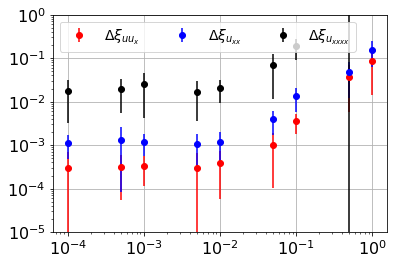

In [7]:
delta_c1_mean = np.nanmean(delta_c1, axis=0)
delta_c2_mean = np.nanmean(delta_c2, axis=0)
delta_c3_mean = np.nanmean(delta_c3, axis=0)

delta_c1_std = np.nanstd(delta_c1, axis=0)
delta_c2_std = np.nanstd(delta_c2, axis=0)
delta_c3_std = np.nanstd(delta_c3, axis=0)

plt.figure()
plt.errorbar(noise_levels, y=delta_c1_mean, yerr=delta_c1_std, color='r', fmt='o', label=r'$\Delta\xi_{uu_x}$')
plt.errorbar(noise_levels, y=delta_c2_mean, yerr=delta_c2_std, color='b', fmt='o', label=r'$\Delta\xi_{u_{xx}}$')
plt.errorbar(noise_levels, y=delta_c3_mean, yerr=delta_c3_std, color='k', fmt='o', label=r'$\Delta\xi_{u_{xxxx}}$')
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=14, loc='upper left', ncol=3)  #, framealpha=1.0, bbox_to_anchor=(1.05, 1))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
ax = plt.gca()
ax.set_ylim(1e-5, 1)
plt.savefig('SR3_weakformPDE_KS.pdf')

# Test weak form PDE functionality on Reaction-Diffusion system
This 2D system is significantly more complicated. The reaction-diffusion system exhibits spiral waves on a periodic domain,and the PDEs are:
$$u_t = 0.1\nabla^2 u + (1-A^2)u +\beta A^2v$$
$$v_t = 0.1\nabla^2 v - \beta A^2 u + (1-A^2)v$$
$$A^2 = u^2 + v^2.$$
The main change will be a significantly larger library... cubic terms in (u, v) and all their first and second order derivatives. We will also need to generate the data. 

(64,) (64,)


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


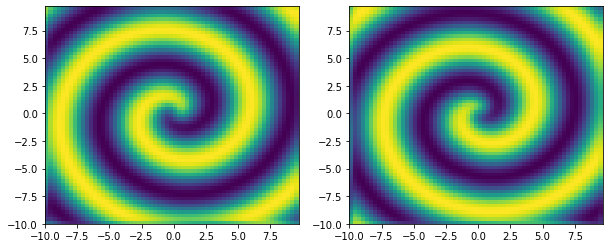

In [8]:
from scipy.integrate import solve_ivp
from numpy.fft import fft2, ifft2

# Define the PDE
def reaction_diffusion(t, uvt, K22, d1, d2, beta, n, N):
    ut = np.reshape(uvt[:N], (n, n))
    vt = np.reshape(uvt[N:2 * N], (n, n))
    u = np.real(ifft2(ut))
    v = np.real(ifft2(vt))
    u3 = u ** 3
    v3 = v ** 3
    u2v = (u ** 2) * v
    uv2 = u * (v ** 2)
    utrhs = np.reshape((fft2(u - u3 - uv2 + beta * u2v + beta * v3)), (N, 1))
    vtrhs = np.reshape((fft2(v - u2v - v3 - beta * u3 - beta * uv2)), (N, 1))
    uvt_reshaped = np.reshape(uvt, (len(uvt), 1))
    uvt_updated = np.squeeze(np.vstack((-d1 * K22 * uvt_reshaped[:N] + utrhs, -d2 * K22 * uvt_reshaped[N:] + vtrhs)))
    return uvt_updated


# Generate the data
time = np.linspace(0, 10, int(10 / 0.05))
d1 = 0.1
d2 = 0.1
beta = 1.0
L = 20
n = 64  # 64 for speed but high-order derivatives are terrible
N = n * n;
x2 = np.linspace(- L / 2, L / 2, n + 1)
x = x2[:n]
y = x
n2 = int(n / 2)
kx = (2 * np.pi / L) * np.hstack((np.linspace(0, n2 - 1, n2), np.linspace(- n2, - 1, n2)))
ky = kx
print(x.shape, kx.shape)
X, Y = np.meshgrid(x, y)
KX, KY = np.meshgrid(kx, ky)
K2 = KX ** 2 + KY ** 2
K22 = np.reshape(K2, (N, 1))

m = 1  # number of spirals

u = np.zeros((len(x), len(y), len(time)))
v = np.zeros((len(x), len(y), len(time)))

# Initial conditions
u[:, :, 0] = np.tanh(np.sqrt(X ** 2 + Y ** 2)) * np.cos(m * np.angle(X + 1j * Y) - (np.sqrt(X ** 2 + Y ** 2)))
v[:, :, 0] = np.tanh(np.sqrt(X ** 2 + Y ** 2)) * np.sin(m * np.angle(X + 1j * Y) - (np.sqrt(X ** 2 + Y ** 2)))
uvt = np.squeeze(np.hstack((np.reshape(fft2(u[:, :, 0]), (1, N)), np.reshape(fft2(v[:, :, 0]), (1, N)))))

# Solve the PDE
uvsol = solve_ivp(reaction_diffusion, (time[0], time[-1]), y0=uvt, t_eval=time, args=(K22, d1, d2, beta, n, N))
uvsol = uvsol.y

# Reshape things and ifft back into (x, y, t) space from (kx, ky, t) space
for j in range(len(time)):
    ut = np.reshape(uvsol[:N, j], (n, n))
    vt = np.reshape(uvsol[N:, j], (n, n))
    u[:, :, j] = np.real(ifft2(ut))
    v[:, :, j] = np.real(ifft2(vt))

# Plot to check if spiral is nicely reproduced
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolor(X, Y, u[:, :, 10])
plt.subplot(1, 2, 2)
plt.pcolor(X, Y, v[:, :, 10])

dt = time[1] - time[0]
dx = x[1] - x[0]
dy = y[1] - y[0]

u_sol = u
v_sol = v

In [9]:
u = np.zeros((n, n, len(time), 2))
u[:, :, :, 0] = u_sol
u[:, :, :, 1] = v_sol
u_flattened = np.reshape(u, (N * len(time), 2))

# Odd polynomial terms in (u, v), up to second order derivatives in (u, v)
library_functions = [lambda x: x, lambda x: x * x * x, lambda x, y: x * y * y, lambda x, y: x * x * y]
library_function_names = [lambda x: x, lambda x: x + x + x, lambda x, y: x + y + y, lambda x, y: x + x + y]
# pde_lib = ps.PDELibrary(library_functions=library_functions, function_names=library_function_names, 
#                         derivative_order=2, spatial_grid=spatial_grid, include_bias=True, is_uniform=True)

X, Y = np.meshgrid(x, y)
spatial_grid = np.asarray([X, Y]).T
pde_lib = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=2, spatial_grid=spatial_grid,
                        temporal_grid=time, include_bias=False,
                        is_uniform=True, weak_form=True, num_pts_per_domain=30)

In [10]:
from scipy.interpolate import RegularGridInterpolator

# Convert ut into a weak form using the pde_lib
def convert_ut_2D(u, pde_lib):
    K = pde_lib.K
    domain_centers = pde_lib.domain_centers
    Hx = pde_lib.Hx
    Hy = pde_lib.Hy
    Ht = pde_lib.Ht
    num_pts_per_domain = pde_lib.num_pts_per_domain
    num_time = len(time)
    ut_integral = np.zeros((K, 2))
    u_shaped = np.reshape(u, (n, n, len(time), 2))
    for j in range(2):
        u_interp = RegularGridInterpolator((x, y, time), u_shaped[:, :, :, j])
        for k in range(K):
            X = np.ravel(pde_lib.X[k, :])
            Y = np.ravel(pde_lib.Y[k, :])
            t = np.ravel(pde_lib.t[k, :])
            XYt = np.array((X, Y, t)).T
            u_new = u_interp(XYt)
            u_new = np.reshape(u_new, (num_pts_per_domain,
                                       num_pts_per_domain,
                                       num_pts_per_domain,
                                       1))
            w_diff = pde_lib._smooth_ppoly(
                        np.transpose((pde_lib.xgrid_k[k, :], pde_lib.ygrid_k[k, :])),
                        pde_lib.tgrid_k[k, :], k, 0, 0, 1
                    )
            ut_integral[k, j] = (-1) * (
                trapezoid(
                    trapezoid(
                        trapezoid(
                            u_new * w_diff, x=pde_lib.xgrid_k[k, :], axis=0
                        ),
                        x=pde_lib.ygrid_k[k, :],
                        axis=0
                    ),
                    x=pde_lib.tgrid_k[k, :], 
                    axis=0
                )
            )
    return ut_integral

ut_integral = convert_ut_2D(u, pde_lib)

In [11]:
optimizer = ps.STLSQ(threshold=0.05, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_flattened, x_dot=ut_integral)
model.print()

x0' = 1.000 x0 + -1.000 x0x0x0 + 1.000 x1x1x1 + -1.000 x0x1x1 + 1.000 x0x0x1 + 0.100 x0_11 + 0.100 x0_22
x1' = 1.000 x1 + -1.000 x0x0x0 + -1.000 x1x1x1 + -1.000 x0x1x1 + -1.000 x0x0x1 + 0.100 x1_11 + 0.100 x1_22
